# Evaluation de la hauteur de boue à l'aide d'un modèle CNN

On va maintenant utiliser un modèle CNN pour l'évaluation de la hauteur de boue à partir du Dataset Intermédiaire :

* Cette étape nécessite la création du dataset intermédiaire à partir du fichier "Dataset_Intermediaire.ipynb".
* La vérification du Dataset de base, à savoir la structure .csv et .xlx


1.   Pour les dossiers avec un excel, le fichier .xlx doit etre à la racine du dossier, avec ensuite chaque sous dossier pour les étangs.
2.   Pour les dossiers avec un .csv, chaque fichier .csv doit être dans chaque sous dossier d'étang.



# Environnement virtuel

In [ ]:
python -m venv env

source env/bin/activate

pip install --upgrade pip
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
pip install pandas matplotlib pillow tqdm opencv-python scikit-learn



# Connexion au drive et import

In [ ]:
# === 1. Importations ===
import torch
import math
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from torchvision import transforms as T
import torchvision.transforms.functional as F

from PIL import Image

from torch.utils.tensorboard import SummaryWriter

# Connexion correcte à Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Spécifier le nom du répertoire
#name_rep = "/231013-STSI-E01"
base_path = "/content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire" # + name_rep

Mounted at /content/drive


# Traitement des fichiers .xlx

Le but ici est d'avoir des .csv dans chaques sous dossiers d'étang -E01 -E02.. , donc si il n'y a qu'un seul fichier .xlx de le transformer en plusieurs fichiers .csv pour chaque etang

In [ ]:
import os
import pandas as pd

def generate_csvs_with_filenames_from_excel(base_path):
    # Parcourt récursivement les sous-dossiers
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".xlsx"):
                excel_path = os.path.join(root, file)
                try:
                    xls = pd.ExcelFile(excel_path)
                    sheet_names = xls.sheet_names
                    print(f" Fichier Excel détecté : {excel_path} avec {len(sheet_names)} onglets")
                except Exception as e:
                    print(f"Erreur d'ouverture de {excel_path} : {e}")
                    continue

                # Récupère tous les sous-dossiers du dossier contenant l'Excel
                subdirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]

                for idx, sheet_name in enumerate(sheet_names):
                    suffix = f"E{idx+1:02d}"  # Onglet 0 → "E01", onglet 1 → "E02", etc.
                    matching_dirs = [d for d in subdirs if suffix in d]

                    for match in matching_dirs:
                        sheet_path = os.path.join(root, match)

                        # Détection ligne exemple
                        try:
                            preview = pd.read_excel(excel_path, sheet_name=sheet_name, usecols="B", nrows=1).iloc[0, 0]
                            skiprows = 1 if preview != 1 else 0
                        except:
                            skiprows = 0

                        try:
                            # Lecture des labels (colonne C) + suppression des lignes vides
                            df_labels = pd.read_excel(
                                excel_path,
                                sheet_name=sheet_name,
                                usecols="C",
                                skiprows=skiprows
                            ).dropna()
                            df_labels.columns = ["label"]

                            # Liste des fichiers image
                            image_files = sorted([
                                f for f in os.listdir(sheet_path)
                                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
                            ])

                            if len(df_labels) != len(image_files):
                                print(f" Mismatch {sheet_path} : {len(image_files)} images vs {len(df_labels)} labels")
                                continue

                            # Ajout des noms de fichiers
                            df_labels["filename"] = image_files
                            df_labels = df_labels[["filename", "label"]]

                            # Écriture du CSV
                            csv_path = os.path.join(sheet_path, "labels_from_excel.csv")
                            df_labels.to_csv(csv_path, index=False)
                            print(f" CSV généré pour {match} : {csv_path}")
                        except Exception as e:
                            print(f"Erreur lecture feuille {sheet_name} ou écriture CSV : {e}")

generate_csvs_with_filenames_from_excel("/content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire")


 Fichier Excel détecté : /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/231013-STSI/Rapport de MissionECH - STSI - 231020.xlsx avec 3 onglets
 CSV généré pour 231013-STSI-E01 : /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/231013-STSI/231013-STSI-E01/labels_from_excel.csv
 CSV généré pour 231013-STSI-E02 : /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/231013-STSI/231013-STSI-E02/labels_from_excel.csv
 CSV généré pour 231013-STSI-E03 : /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/231013-STSI/231013-STSI-E03/labels_from_excel.csv
 Fichier Excel détecté : /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/220913-STSI/Rapport de MissionECH - STSI - 220913.xlsx avec 3 onglets
 CSV généré pour 2220913-STSI-E01 : /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/220913-STSI/2220913-STSI-E01/labels_from_excel.csv
 CSV généré pour 2220913-STSI-E02 : /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/22091

# Prédiction des hauteurs de boue

## Génération du .csv global

Génération d'un fichier .csv global pour l'entraînement du modèle de régression

In [ ]:
import os
import pandas as pd

def collect_global_dataset_from_csvs(base_path, output_csv="Dataset_paths_labels_auto.csv"):
    data = []
    errors = {
        "csv_read_errors": [],
        "label_conversion_errors": [],
        "missing_images": [],
        "files_processed": 0,
        "total_images_expected": 0,
        "total_images_ok": 0,
        "files_logged": []
    }

    for root, _, files in os.walk(base_path):
        csv_files = [f for f in files if f.endswith('.csv') and not f.startswith("~$")]

        for csv_file in csv_files:
            csv_path = os.path.join(root, csv_file)
            try:
                df = pd.read_csv(csv_path)
                df.columns = [col.strip() for col in df.columns]  # Nettoyage d'espace

                errors["files_processed"] += 1
                errors["total_images_expected"] += len(df)

                # Détection stricte de la colonne label
                if "Hauteur de boue dans la jauge (cm)" in df.columns:
                    label_col = "Hauteur de boue dans la jauge (cm)"
                elif "label" in df.columns:
                    label_col = "label"
                else:
                    errors["label_conversion_errors"].append((csv_path, f"Colonnes disponibles : {list(df.columns)}"))
                    continue

                filename_col = 'filename' if 'filename' in df.columns else df.columns[0]
                errors["files_logged"].append((csv_path, filename_col, label_col))

                # Cas 1 : Identifiants numériques → correspondance par ordre
                is_numeric_ids = df[filename_col].dropna().apply(lambda x: str(x).isdigit()).all()
                if is_numeric_ids:
                    all_imgs = sorted([
                        f for f in os.listdir(root)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
                    ])
                    if len(all_imgs) != len(df):
                        errors["label_conversion_errors"].append(
                            (csv_path, f"{len(df)} labels mais {len(all_imgs)} images"))
                        continue

                    for img_file, (_, row) in zip(all_imgs, df.iterrows()):
                        try:
                            label = float(row[label_col])
                            full_img_path = os.path.join(root, img_file)
                            data.append({'full_path': full_img_path, 'labels': label})
                            errors["total_images_ok"] += 1
                        except:
                            errors["label_conversion_errors"].append((csv_path, img_file, row[label_col]))

                else:
                    # Cas 2 : correspondance directe avec noms d’images
                    for _, row in df.iterrows():
                        img_name = str(row[filename_col])
                        try:
                            label_val = row[label_col]
                            label = float(label_val)
                        except:
                            errors["label_conversion_errors"].append((csv_path, img_name, label_val))
                            continue

                        img_candidates = [
                            f for f in os.listdir(root)
                            if f.lower().startswith(os.path.splitext(img_name.lower())[0])
                        ]
                        if img_candidates:
                            full_img_path = os.path.join(root, img_candidates[0])
                            data.append({'full_path': full_img_path, 'labels': label})
                            errors["total_images_ok"] += 1
                        else:
                            errors["missing_images"].append(os.path.join(root, img_name))

            except Exception as e:
                errors["csv_read_errors"].append((csv_path, str(e)))

    # Sauvegarde finale
    df = pd.DataFrame(data)
    output_path = os.path.join(base_path, output_csv)
    df.to_csv(output_path, index=False)

    print(f"\n CSV global sauvegardé : {output_path} ({len(df)} entrées)")
    print(" Résumé :")
    print(f"- Fichiers CSV traités : {errors['files_processed']}")
    print(f"- Images attendues : {errors['total_images_expected']}")
    print(f"- Images valides : {errors['total_images_ok']}")
    print(f"- Images manquantes : {len(errors['missing_images'])}")
    print(f"- Erreurs de lecture : {len(errors['csv_read_errors'])}")
    print(f"- Erreurs de conversion de labels : {len(errors['label_conversion_errors'])}")
    print("\n Fichiers inclus avec colonnes reconnues :")
    for path, col_img, col_label in errors["files_logged"]:
        print(f"  - {path}  [image: '{col_img}' | label: '{col_label}']")

    if errors["label_conversion_errors"]:
        print("\n Erreurs de conversion de labels détaillées :")
        for e in errors["label_conversion_errors"]:
            print(f"  - {e}")

    return df, errors

df, logs = collect_global_dataset_from_csvs("/content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire")



✅ CSV global sauvegardé : /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/Dataset_paths_labels_auto.csv (1202 entrées)
🔍 Résumé :
- Fichiers CSV traités : 22
- Images attendues : 1964
- Images valides : 1202
- Images manquantes : 0
- Erreurs de lecture : 0
- Erreurs de conversion de labels : 5

📁 Fichiers inclus avec colonnes reconnues :
  - /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/250319-IVEO-LVLT/250319-IVEO-LVLT-EO1/250319-LTRI-E01.csv  [image: 'ID' | label: 'Hauteur de boue dans la jauge (cm)']
  - /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/240507-IVEO-LVLT/240507-IVEO-LVLT-E01/240507-LVLT-E01.csv  [image: 'ID' | label: 'Hauteur de boue dans la jauge (cm)']
  - /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/240507-IVEO-LVLT/240507-IVEO-LVLT-E02/240507-LVLT-E02.csv  [image: 'ID' | label: 'Hauteur de boue dans la jauge (cm)']
  - /content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/241031-IVEO-LVLT/241031-LVLT-

# Entrainement avec ResNET34 pour la régression sur 30 epoch

On choisit un ResNet34 pour améliorer l'entrainement là où un CNN simple sur 20 epoch nous donnait une perte final (MSE) pas très précise (+-22cm)

In [ ]:
import os
import pandas as pd
import torch
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# PARAMÈTRES GLOBAUX
csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire/Dataset_paths_labels_auto.csv"
batch_size = 32
img_size = (128, 128)
num_epochs = 30
learning_rate = 1e-3

# CHARGEMENT DU CSV
df = pd.read_csv(csv_path)

# DATASET PYTORCH
class MudLevelDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]["full_path"]
        label = self.dataframe.iloc[idx]["labels"]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor([label], dtype=torch.float32)

# TRANSFORMATIONS & DATALOADER
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

dataset = MudLevelDataset(df, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# RÉSEAU RESNET34 POUR LA RÉGRESSION AVEC GEL PARTIEL
class ResNet34Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        for name, param in self.resnet.named_parameters():
            if "layer4" not in name and "fc" not in name:
                param.requires_grad = False
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        return self.resnet(x)

# INITIALISATION & ENTRAÎNEMENT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34Regressor().to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

train_losses = []
train_maes = []
best_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    mae_total = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for imgs, labels in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = criterion(preds, labels)
        mae = torch.mean(torch.abs(preds - labels)).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        mae_total += mae * imgs.size(0)
        progress_bar.set_postfix(loss=loss.item(), mae=mae)

    avg_loss = running_loss / len(train_loader.dataset)
    avg_mae = mae_total / len(train_loader.dataset)

    train_losses.append(avg_loss)
    train_maes.append(avg_mae)
    scheduler.step(avg_loss)

    print(f"\nEpoch {epoch+1}: MSE = {avg_loss:.4f} | MAE = {avg_mae:.2f} cm")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "best_resnet34_model.pth")
        print("Modèle sauvegardé.")

# COURBES DE PERTE ET MAE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Évolution de la perte d'entraînement (MSE)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_maes, marker='s', color='orange')
plt.xlabel("Epoch")
plt.ylabel("MAE (cm)")
plt.title("Évolution de l'erreur absolue moyenne (MAE)")
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/30:   3%|▎         | 1/31 [00:39<19:50, 39.70s/it, loss=62.4, mae=62.8]


KeyboardInterrupt: 

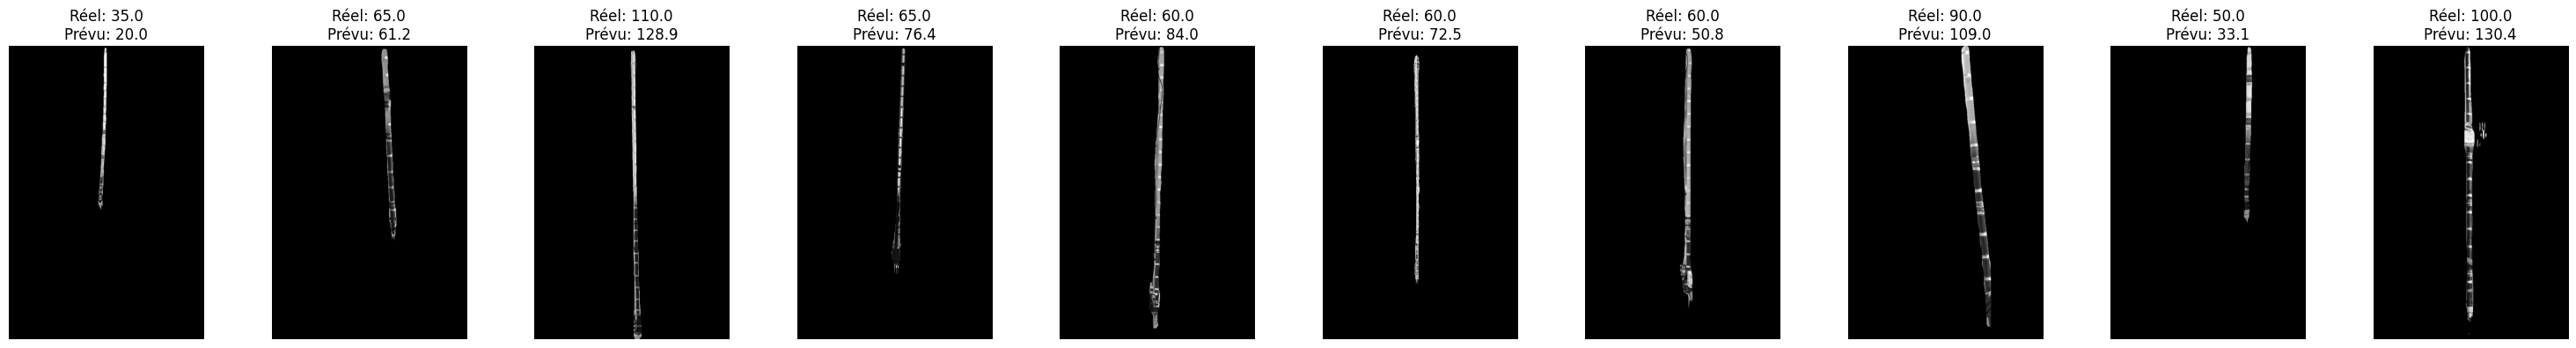

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Charger le meilleur modèle sauvegardé
model.load_state_dict(torch.load("best_resnet34_model.pth", map_location=device))
model.eval()

def test_random_images(model, dataframe, transform, device, n=10):
    model.eval()
    samples = dataframe.sample(n)

    fig, axes = plt.subplots(1, n, figsize=(3 * n, 4))
    if n == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, samples.iterrows()):
        img_path = row['full_path']
        true_label = row['labels']

        image = Image.open(img_path).convert("L")
        input_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(input_tensor).cpu().item()

        ax.imshow(image, cmap="gray")
        ax.axis("off")
        ax.set_title(f"Réel: {true_label:.1f}\nPrévu: {pred:.1f}")

    plt.tight_layout()
    plt.show()

# Appel de la fonction
test_random_images(model, df, transform, device)

## Evaluation du modèle

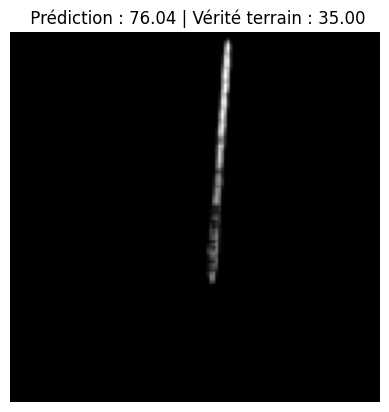

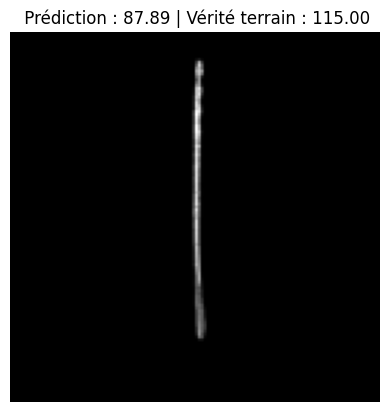

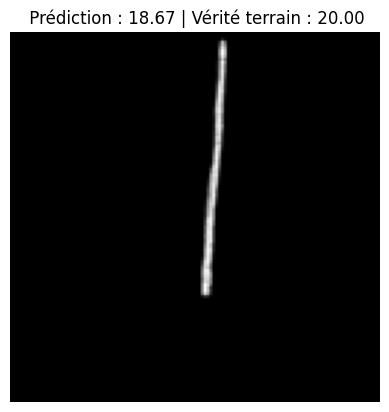

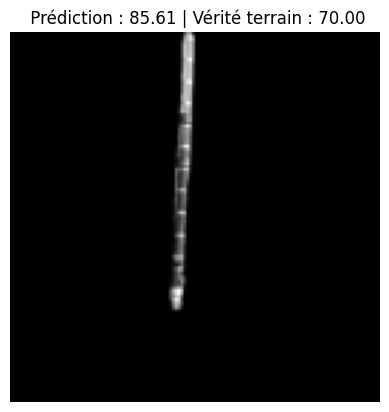

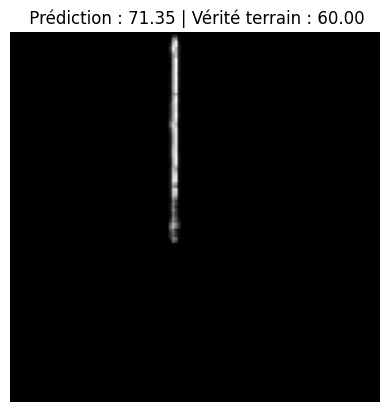

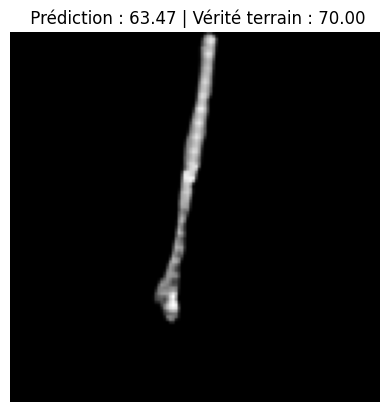

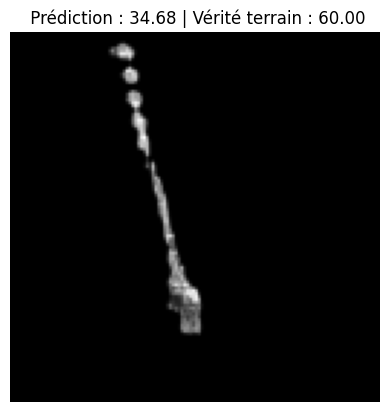

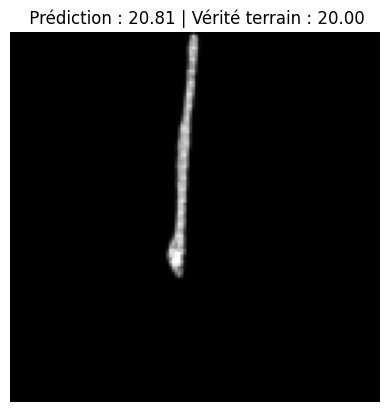

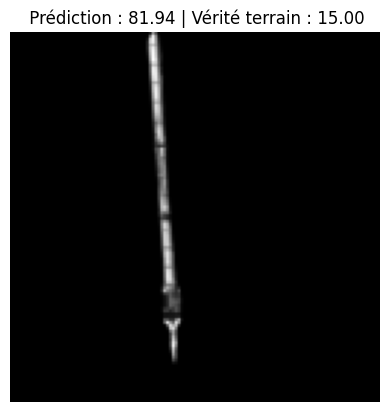

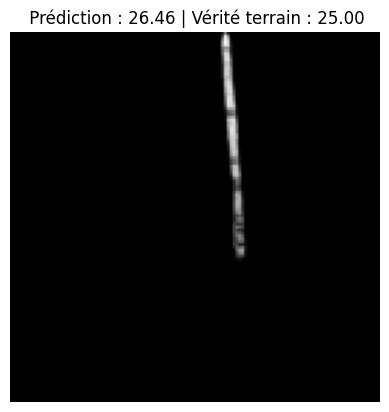

In [ ]:
import random
import matplotlib.pyplot as plt

def show_multiple_predictions(model, test_dataset, n=10, device='cuda'):
    model.eval()
    indices = random.sample(range(len(test_dataset)), n)

    for idx in indices:
        image, true_label = test_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(image_batch).item()

        # Affichage
        plt.imshow(image.permute(1, 2, 0).cpu(), cmap="gray")
        plt.title(f" Prédiction : {pred:.2f} | Vérité terrain : {true_label.item():.2f}")
        plt.axis("off")
        plt.show()

show_multiple_predictions(model, test_dataset, n=10)


## Sans Excel

### Mise en forme des images pour être interprétées par le modèle de classification sans Excel

path_dp: /content/drive/MyDrive/Stage_DDC/dossier_test/ local_folder: dossier_test/
Chemin du dossier principal: /content/drive/MyDrive/Stage_DDC/dossier_test/
Liste des étangs: ['2220913-STSI-E01', '2220913-STSI-E02', '2220913-STSI-E03'] Nombre d'étangs 3
2220913-STSI-E01
0
2220913-STSI-E02
1
2220913-STSI-E03
2
(15, 41136)


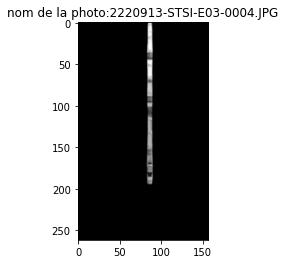

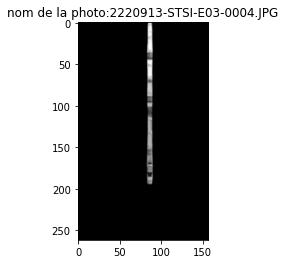

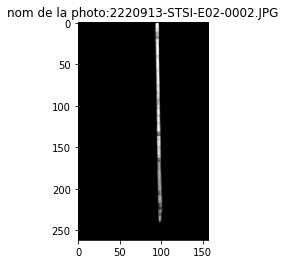

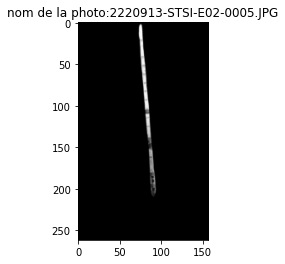

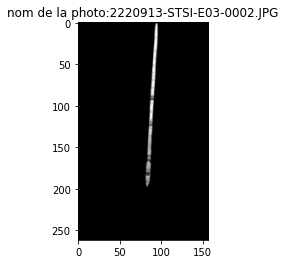

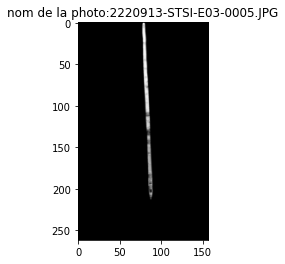

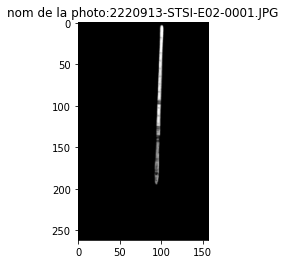

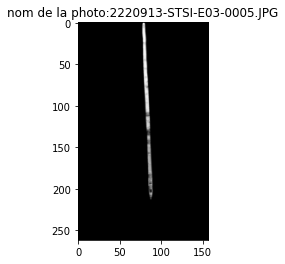

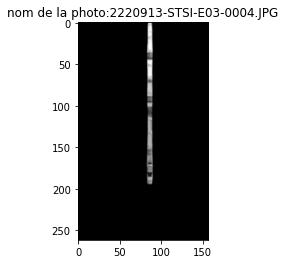

[13, 13, 6, 9, 11, 14, 5, 14, 13]


In [ ]:
import imageio
import numpy as np
import pandas
import pandas as pd
from imageio import imwrite
from skimage.color import rgb2gray
from skimage.transform import rotate, rescale
import os
import matplotlib.pyplot as plt
import xlrd

#----------------------------------Defition de la fonction de traitement des images---------------------------------------
def paysage_to_gray_to_portrait(image):
    """ Fonction qui prend en argument une image en nuances de gris et modifie sa taille en rognant l'image
    sur les cotés et sur le bas avec le paramètre n pour arriver à une taille finale de 262 * 157 pixels"""
    image = plt.imread(image)
    if image.shape[0] < image.shape[1]: # Si le nombre de pixels sur les lignes < au nombre de pixels sur les colonnes
        image = rotate(image,90,resize = True)
        # Penser à jouer sur le centre de masse de l'image pour trouver le bon sens de rotation et de multiplier 90 par -1 ou non si besoin
    image = rescale(image, 1 / 8, anti_aliasing=True)
    image = image * 255
    # On change le type des données de float64 en int pour alléger le dataset
    image = image.astype("int")
    # on retire une proportion p de la taille de l'image p*image.shape[1]
    n = 4
    p = image.shape[1] // n
    image2 = np.array([range(image.shape[1] - p)])
    for i in range(image.shape[0] - p):
        image2 = np.append(image2, [image[i][p // 2:-p // 2]], axis=0)
    image2 = np.delete(image2, (0), axis=0)
    return image2.ravel()

# ----------------------------------------------Construction du dataset-------------------------------------------------
# Définition du dossier principal
path_dp = base_path + "/"
# Nom du répertoire qui contient les répertoires étangs
local_folder = name_rep[1:]
# Initialisation du dataframe des labels
df_labels = pd.DataFrame()
df_photo_1client = pd.DataFrame()
df_photo_tot = pd.DataFrame()
# On entre dans chaque dossier client via l'adresse du dossier principal
# On ne prend pas les 2 derniers repertoires car le dernier est caché et l'avant dernier ne nous interesse pas
print("path_dp:", path_dp,"local_folder:", local_folder + "/")
for path_client_folder in [path_dp ]:
    photos_list_lake_i=[]
    print("Chemin du dossier principal:",path_dp)
# --------------------------------On cherche les photos dans les dossiers étang ------------------------------------
    # --------------------------------on cherche le nombre de dossier étang dans le dossier client----------------------
    # on repère le nom du dossier étang comme ayant le caractère E comme 3éme ou 4éme lettre avant la fin
    lake_folders = sorted([lake_name for lake_name in os.listdir(path_client_folder) if (lake_name[-3]=="E" or lake_name[-4]=="E")])
    # Le nombre d'étang est la dimension du vecteur contenant les noms des dossiers étang
    nb_lake_folders = len(lake_folders)
    print("Liste des étangs:",lake_folders,"Nombre d'étangs",nb_lake_folders)
    # Il faut ajouter le nom du dossier étang 2 fois pour accéder aux photos basses définitions
    j=0
    photos_list_lake_client=[]
    for lake_i in lake_folders:

        # Accès au dossier correspondant à l'étang i contenant les photos
        path_photos_lake_i = path_client_folder+"/"+lake_i+"/"+lake_i+"_resize_2514_1671_filtree"
        # print(path_photos_lake_i)
        photos_list_lake_i = os.listdir(path_photos_lake_i)
        photos_list_lake_client += photos_list_lake_i
        # print("nombre de photo pour {}".format(lake_i),len(photos_list_lake_i))
        # on créée le data frame pour 1 étang
        # On commence par prendre le nom des photos
        df_names_photo = pd.DataFrame({"photos_names": os.listdir(path_photos_lake_i)})
        #print(df_names_photo)
        # On crééer le dataframe photo
        # On commence par créer les index des colonnes correspondant à chaque pixel de 1 au nombre de pixels dans l'image
        index_pixel = ["pixel{}".format(i+1) for i in range(len(paysage_to_gray_to_portrait(path_photos_lake_i+"/"+photos_list_lake_i[0])))]
        #print(index_pixel[0],index_pixel[-1])
        # print(path_photos_lake_i+"/"+photos_list_lake_i[0])
        # print(photos_list_lake_client)
        # Pour chaque photo de l'étang i on ajoute les pixels sur chaque ligne
        # Pour chaque photo dans le dossier étang
        np_photo_1lake = np.array([range(len(index_pixel))]) # On initialise le tableau numpy à la taille du nombre de pixels
        for photo in photos_list_lake_i:
            #print(photo)
            np_photo_1lake = np.append(np_photo_1lake,[np.array(paysage_to_gray_to_portrait(path_photos_lake_i+"/"+photo))],axis=0)
        # On retire la ligne d'initialisation du tableau
        np_photo_1lake = np.delete(np_photo_1lake,(0),axis=0)
        # On créée le tableau avec les noms des photos
        df_photo_1lake = pd.DataFrame(np_photo_1lake).assign(photos_names=df_names_photo["photos_names"].tolist())
        # On ajoute les photos des différents étangs
        df_photo_1client = pd.concat([df_photo_1client,df_photo_1lake],ignore_index=True)
        #print("df_photo_1client",df_photo_1client.shape)
        j+=1


# -------------------------On met les labels à la valeur 0 -----------------------------------

    # pour chaque étang on extrait les labels avec le nom des photos
    i = 0
    df_labels_1client = pd.DataFrame() # on initialise le dataframe client
    for lake_i in lake_folders:
        print(lake_i)
        print(i)
        path_photos_lake_i = path_client_folder + "/" + lake_i + "/" + lake_i+"_resize_2514_1671_filtree"
        df_names = pd.DataFrame({"photos_names": os.listdir(path_photos_lake_i)})
        df_names.shape
        labels = pd.DataFrame({"labels":[0 for i in os.listdir(path_photos_lake_i)]})
        df_labels_1lake = df_names.assign(labels=labels["labels"].tolist())  # on ajoute la colonne des labels aux noms des photos pour un étang
        df_labels_1client = pd.concat([df_labels_1client, df_labels_1lake], ignore_index=True) # on ajoute les lignes pour chaque étang
        # print(labels)
        # print(df_names)
        i += 1
    df_labels = pd.concat([df_labels, df_labels_1client], ignore_index=True)
# On replace la colonne "photo names" en première colonne dans df_photo_tot
fc = df_photo_1client.pop("photos_names")
df_photo_1client.insert(0, "photos_names", fc)
# On ajoute la colonne des labels en seconde colonne
sc = df_labels["labels"]
df_photo_1client.insert(1, "labels", sc)
# Création des index du dataframe à partir du nom "photos_names","labels" et index_pixel
index_labels = ["photos_names","labels"] + index_pixel
# print(index_pixel)
df_photo_1client.columns = index_labels
print(df_photo_1client.shape)
# Sauvegarde du dataset en format csv
df_photo_1client.to_csv("Dataset_repertoire_{}_mask_sans_excel.csv".format(local_folder))

# --------------------------------Check du Dataset------------------------------------
# On affiche 1 photo avec le nom de la photo et le label à partir d'une ligne du Dataset
import random

def verification(nb_photo, dataset=df_photo_1client):

    """La fonction prend un dataset  un nombre de photo à vérifier en entrée et affiche des photos prises hasard
    dans le dataset avec son nom et le label en sortie """
    x = [random.randint(0, dataset.shape[0]-1) for p in range(nb_photo-1)]
    for i in x:
        verif = dataset.to_numpy()[i]
        photo_verif = verif[2:].reshape((262, 157))
        photo_verif = photo_verif.astype("float64")
        plt.imshow(photo_verif, "gray")
        plt.title("nom de la photo:{}".format(verif[0]))
        plt.show()
    return print(x)

verification(10)


### Prédictions des hauteurs de boue sans excel

#### Importation du modèle, des données et des librairies

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix

In [ ]:
df_new_ss_excel = pd.read_csv("Dataset_repertoire_{}_mask_sans_excel.csv".format(local_folder), sep=",")

In [ ]:
# Il faut importer le dossier 'my_best_model' contentant le modèle dans le drive
model = tf.keras.models.load_model("/content/drive/MyDrive/Stage_DDC/my_best_model") # Penser à mettre l'adresse du dossier à jour

### Evaluation des hauteurs de boue

(15, 41136)


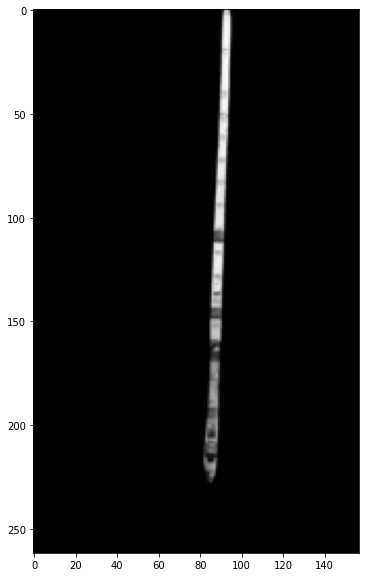

2220913-STSI-E02-0004.JPG


In [ ]:
print(df_new_ss_excel.shape)
del df_new_ss_excel["Unnamed: 0"]
Noms_photos = df_new_ss_excel['photos_names']
# Creation du dataset
X = df_new_ss_excel.drop(labels = ['photos_names','labels'],axis = 1)
X = X/255
X = X.values.reshape(-1,262,157,1)
# one example
n=8
plt.figure(figsize=(10,10))
plt.imshow(X[n][:,:,0],cmap='gray')
plt.show()
print(Noms_photos[n])

In [ ]:
# Predict the values from the validation dataset
Y_pred_new = model.predict(X)
# Convert predictions classes to one hot vectors
Y_pred_new_classes = np.argmax(Y_pred_new,axis = 1)
# Convert to feet and cm units
Y_pred_new_classes_feet = Y_pred_new_classes*0.25
Y_pred_new_classes_cm = Y_pred_new_classes_feet * 30
print(Y_pred_new_classes,Y_pred_new_classes_feet,Y_pred_new_classes_cm)
df_sans_excel = pd.DataFrame({"Nom_photo":Noms_photos,"Prediction_pieds":Y_pred_new_classes_feet,"Predictions_cm":Y_pred_new_classes_cm})
df_sans_excel.head()

[1 3 3 5 6 1 0 1 2 5 3 0 3 1 0] [0.25 0.75 0.75 1.25 1.5  0.25 0.   0.25 0.5  1.25 0.75 0.   0.75 0.25
 0.  ] [ 7.5 22.5 22.5 37.5 45.   7.5  0.   7.5 15.  37.5 22.5  0.  22.5  7.5
  0. ]


,Nom_photo,Prediction_pieds,Predictions_cm
0,2220913-STSI-E01-0001.JPG,0.25,7.5
1,2220913-STSI-E01-0002.JPG,0.75,22.5
2,2220913-STSI-E01-0003.JPG,0.75,22.5
3,2220913-STSI-E01-0004.JPG,1.25,37.5
4,2220913-STSI-E01-0005.JPG,1.50,45.0


In [ ]:
df_sans_excel.to_csv("Prédictions_hauteurs_de_boue_mission_{}.csv".format(name_rep[1:]))

## Avec Excel

### Mise en forme des images pour être interprétées par le modèle de classification avec Excel

path_dp: /content/drive/MyDrive/Stage_DDC/dossier_test/ local_folder: dossier_test/
Chemin du dossier principal: /content/drive/MyDrive/Stage_DDC/dossier_test/
Liste des étangs: ['2220913-STSI-E01', '2220913-STSI-E02', '2220913-STSI-E03'] Nombre d'étangs 3
['Rapport de MissionECH - STSI - 220913.xlsx']
2220913-STSI-E01
0
2220913-STSI-E02
1
2220913-STSI-E03
2
(15, 41136)


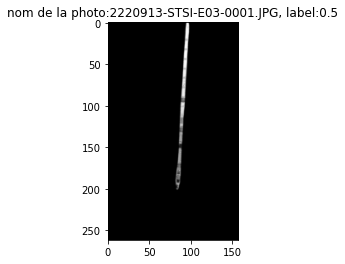

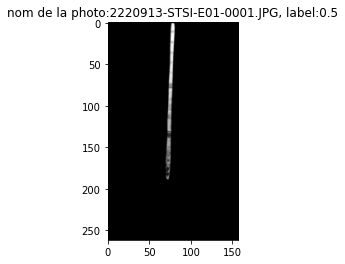

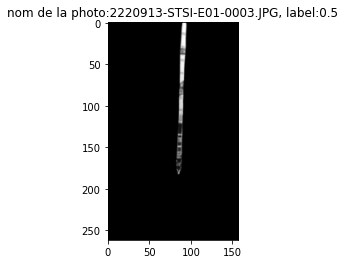

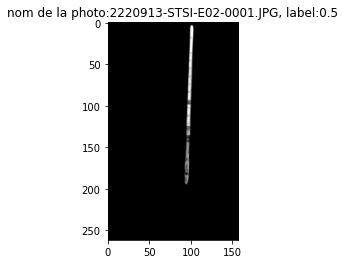

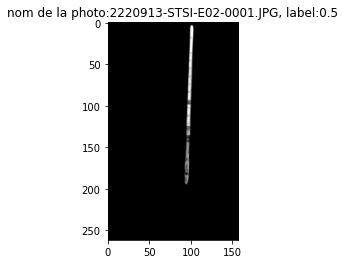

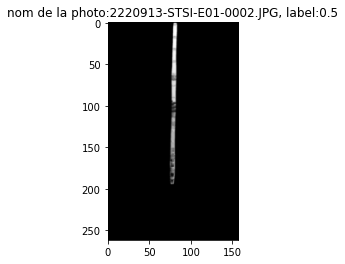

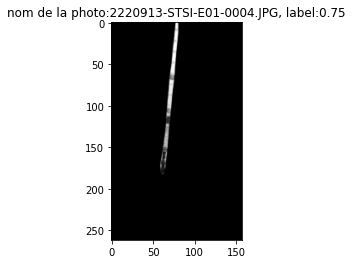

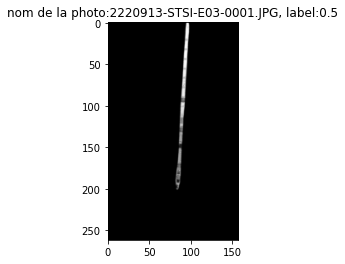

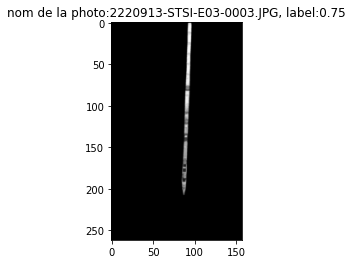

[10, 0, 2, 5, 5, 1, 3, 10, 12] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75]


In [ ]:
import imageio
import numpy as np
import pandas
import pandas as pd
from imageio import imwrite
from skimage.color import rgb2gray
from skimage.transform import rotate, rescale
import os
import matplotlib.pyplot as plt
import xlrd

#----------------------------------Defition de la fonction de traitement des images---------------------------------------
def paysage_to_gray_to_portrait(image):
    """ Fonction qui prend en argument une image en nuances de gris et modifie sa taille en rognant l'image
    sur les cotés et sur le bas avec le paramètre n pour arriver à une taille finale de 262 * 157 pixels"""
    image = plt.imread(image)
    if image.shape[0] < image.shape[1]: # Si le nombre de pixels sur les lignes < au nombre de pixels sur les colonnes
        image = rotate(image,90,resize = True)
        # Penser à jouer sur le centre de masse de l'image pour trouver le bon sens de rotation et de multiplier 90 par -1 ou non si besoin
    image = rescale(image, 1 / 8, anti_aliasing=True)
    image = image * 255
    # On change le type des données de float64 en int pour alléger le dataset
    image = image.astype("int")
    # on retire une proportion p de la taille de l'image p*image.shape[1]
    n = 4
    p = image.shape[1] // n
    image2 = np.array([range(image.shape[1] - p)])
    for i in range(image.shape[0] - p):
        image2 = np.append(image2, [image[i][p // 2:-p // 2]], axis=0)
    image2 = np.delete(image2, (0), axis=0)
    return image2.ravel()

#-------------------Definition de la fonction qui sort les labels avec le nom des photos du fichier Excel----------------
def import_labels(address,nom_fichier,nb_sheet):
    #Fonction qui prend en entrée une adresse du fichier Excel, son nom de fichier, et le numero de l'onglet dans lequel
    #extraire les données et donne en sortie un dataframe contenant le nom des photos dans la première colonne et le
    #label correspondant dans la seconde
    # On considère qu'uniquement la colonne C du fichier est utilisée, la ligne 2 exemple n'est pas prise en compte
    fichier_xls = pd.read_excel(adresse_xl+nom_fichier_xls[0],usecols="C",skiprows=1,nrows=len(os.listdir(adresse_l)))
    df = fichier_xls.assign(Photo_names = os.listdir(adresse_l))
    df1 = df.set_index("Photo_names")
    return df1

# ----------------------------------------------Construction du dataset-------------------------------------------------
# Définition du dossier principal
path_dp = base_path + "/"
# Nom du répertoire qui contient les répertoires étangs
local_folder = name_rep[1:]
# Initialisation du dataframe des labels
df_labels = pd.DataFrame()
df_photo_1client = pd.DataFrame()
df_photo_tot = pd.DataFrame()
# On entre dans chaque dossier client via l'adresse du dossier principal
# On ne prend pas les 2 derniers repertoires car le dernier est caché et l'avant dernier ne nous interesse pas
print("path_dp:", path_dp,"local_folder:", local_folder + "/")
for path_client_folder in [path_dp ]:
    photos_list_lake_i=[]
    print("Chemin du dossier principal:",path_dp)
# --------------------------------On cherche les photos dans les dossiers étang ------------------------------------
    # --------------------------------on cherche le nombre de dossier étang dans le dossier client----------------------
    # on repère le nom du dossier étang comme ayant le caractère E comme 3éme ou 4éme lettre avant la fin
    lake_folders = sorted([lake_name for lake_name in os.listdir(path_client_folder) if (lake_name[-3]=="E" or lake_name[-4]=="E")])
    # Le nombre d'étang est la dimension du vecteur contenant les noms des dossiers étang
    nb_lake_folders = len(lake_folders)
    print("Liste des étangs:",lake_folders,"Nombre d'étangs",nb_lake_folders)
    # Il faut ajouter le nom du dossier étang 2 fois pour accéder aux photos basses définitions
    j=0
    photos_list_lake_client=[]
    for lake_i in lake_folders:

        # Accès au dossier correspondant à l'étang i contenant les photos
        path_photos_lake_i = path_client_folder+"/"+lake_i+"/"+lake_i+"_resize_2514_1671_filtree"
        # print(path_photos_lake_i)
        photos_list_lake_i = os.listdir(path_photos_lake_i)
        photos_list_lake_client += photos_list_lake_i
        # print("nombre de photo pour {}".format(lake_i),len(photos_list_lake_i))
        # on créée le data frame pour 1 étang
        # On commence par prendre le nom des photos
        df_names_photo = pd.DataFrame({"photos_names": os.listdir(path_photos_lake_i)})
        #print(df_names_photo)
        # On crééer le dataframe photo
        # On commence par créer les index des colonnes correspondant à chaque pixel de 1 au nombre de pixels dans l'image
        index_pixel = ["pixel{}".format(i+1) for i in range(len(paysage_to_gray_to_portrait(path_photos_lake_i+"/"+photos_list_lake_i[0])))]
        #print(index_pixel[0],index_pixel[-1])
        # print(path_photos_lake_i+"/"+photos_list_lake_i[0])
        # print(photos_list_lake_client)
        # Pour chaque photo de l'étang i on ajoute les pixels sur chaque ligne
        # Pour chaque photo dans le dossier étang
        np_photo_1lake = np.array([range(len(index_pixel))]) # On initialise le tableau numpy à la taille du nombre de pixels
        for photo in photos_list_lake_i:
            #print(photo)
            np_photo_1lake = np.append(np_photo_1lake,[np.array(paysage_to_gray_to_portrait(path_photos_lake_i+"/"+photo))],axis=0)
        # On retire la ligne d'initialisation du tableau
        np_photo_1lake = np.delete(np_photo_1lake,(0),axis=0)
        # On créée le tableau avec les noms des photos
        df_photo_1lake = pd.DataFrame(np_photo_1lake).assign(photos_names=df_names_photo["photos_names"].tolist())
        # On ajoute les photos des différents étangs
        df_photo_1client = pd.concat([df_photo_1client,df_photo_1lake],ignore_index=True)
        #print("df_photo_1client",df_photo_1client.shape)
        j+=1


# -------------------------On cherche le fichier Excel pour en sortir les labels dans un tableau Numpy
    # Recherche du fichier xlsx dans le repertoire
    # Doit se terminer par .xlsx et commencer par "Tableau des hauteursECH"
    nom_file_xls = [i for i in os.listdir(path_client_folder) if (i[-5:]==".xlsx")]
    print(nom_file_xls)
    # pour chaque étang on extrait les labels avec le nom des photos
    i = 0
    df_labels_1client = pd.DataFrame() # on initialise le dataframe client
    for lake_i in lake_folders:
        print(lake_i)
        print(i)
        path_photos_lake_i = path_client_folder + "/" + lake_i + "/" + lake_i+"_resize_2514_1671_filtree"
        df_names = pd.DataFrame({"photos_names": os.listdir(path_photos_lake_i)})
        # recherche dans le fichier Excel la colonne C saute la première ligne corresondant à l'exemple et
        # prend le nb de ligne correspondant aux nombres de photos dans le dossier étang correspondant
        # si la ligne exemple est présente on saute une ligne sinon non
        if pd.read_excel(path_client_folder + "/" + nom_file_xls[0], sheet_name=i, usecols="B", nrows=1).iloc[0, 0] != 1:
            jump_row=1
        else:
            jump_row=0
        # On vérifie qu'il y a le meme nombre de photo que de labels dans le fichier excel
        col_lab = pd.read_excel(path_client_folder + "/" + nom_file_xls[0], sheet_name=i, usecols="C", skiprows=jump_row)
        #print((col_lab.shape[0]-col_lab.isna().sum())[0] != len(os.listdir(path_photos_lake_i)))
        #print((col_lab.shape[0]-col_lab.isna().sum())[0], len(os.listdir(path_photos_lake_i)))
        #print("Il n'y a pas le même nombre de photo et de labels dans le repertoire {}".format(path_photos_lake_i))
        labels = pd.read_excel(path_client_folder + "/" + nom_file_xls[0], sheet_name=i, usecols="C", skiprows=jump_row, nrows=len(os.listdir(path_photos_lake_i)))
        labels.columns = ["labels"] # on nomme la colonne des lables labels
        df_labels_1lake = df_names.assign(labels=labels["labels"].tolist())  # on ajoute la colonne des labels aux noms des photos pour un étang
        df_labels_1client = pd.concat([df_labels_1client, df_labels_1lake], ignore_index=True) # on ajoute les lignes pour chaque étang
        # print(labels)
        # print(df_names)
        i += 1
    df_labels = pd.concat([df_labels, df_labels_1client], ignore_index=True)
# On replace la colonne "photo names" en première colonne dans df_photo_tot
fc = df_photo_1client.pop("photos_names")
df_photo_1client.insert(0, "photos_names", fc)
# On ajoute la colonne des labels en seconde colonne
sc = df_labels["labels"]
df_photo_1client.insert(1, "labels", sc)
# Création des index du dataframe à partir du nom "photos_names","labels" et index_pixel
index_labels = ["photos_names","labels"] + index_pixel
# print(index_pixel)
df_photo_1client.columns = index_labels
print(df_photo_1client.shape)
# Sauvegarde du dataset en format csv
df_photo_1client.to_csv("Dataset_repertoire_{}_mask.csv".format(local_folder))

# --------------------------------Check du Dataset------------------------------------
# On affiche 1 photo avec le nom de la photo et le label à partir d'une ligne du Dataset
import random

def verification(nb_photo, dataset=df_photo_1client):

    """La fonction prend un dataset  un nombre de photo à vérifier en entrée et affiche des photos prises hasard
    dans le dataset avec son nom et le label en sortie """
    x = [random.randint(0, dataset.shape[0]) for p in range(nb_photo-1)]
    lab=[]
    for i in x:
        verif = dataset.to_numpy()[i]
        photo_verif = verif[2:].reshape((262, 157))
        photo_verif = photo_verif.astype("float64")
        plt.imshow(photo_verif, "gray")
        plt.title("nom de la photo:{}, label:{}".format(verif[0], verif[1]))
        lab+=[verif[1]]
        plt.show()
    return print(x,lab)

verification(10)


### Prédictions de volume et hauteurs de boue

#### Importation du modèle, des données et des librairies

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix

In [ ]:
df_new = pd.read_csv("Dataset_repertoire_{}_mask.csv".format(local_folder), sep=",")

In [ ]:
# Il faut importer le dossier 'my_best_model' contentant le modèle dans le drive
model = tf.keras.models.load_model("/content/drive/MyDrive/Stage_DDC/my_best_model") # Penser à mettre l'adresse du dossier à jour

#### Etang 01A


In [ ]:
# Changer les noms pour plus de clarté
# Indiquer les indices pour le premier étang. Ici par exemple on prend les 48 premières lignes, c'est le nombre de photos pour cet étang.
Etang_01A = df_new.iloc[0:40]
Etang_01A.reset_index(drop=True,inplace=True)
Etang_01A.tail()

,Unnamed: 0,photos_names,labels,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel41125,pixel41126,pixel41127,pixel41128,pixel41129,pixel41130,pixel41131,pixel41132,pixel41133,pixel41134
35,35,2220913-STSI-E01-0036.JPG,1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,36,2220913-STSI-E01-0037.JPG,1.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,37,2220913-STSI-E01-0038.JPG,1.50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,38,2220913-STSI-E01-0039.JPG,1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,39,2220913-STSI-E01-0040.JPG,0.50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
base_path + "/" + [i for i in os.listdir(base_path) if i[-4:]=="xlsx"][0]

'/content/drive/MyDrive/Stage_DDC/2220913-STSIMON/Rapport de MissionECH - STSI - 220913.xlsx'

In [ ]:
# Création du dataframe avec les infos de pente et labels
os.listdir(base_path)
pente = pd.read_excel(base_path + "/" + [i for i in os.listdir(base_path) if i[-4:]=="xlsx"][0],sheet_name=0,header=0,usecols="I",nrows=40,na_values=0)
pente.columns=["Pente"]
pente = pente.fillna(0).astype('int')
pente

,Pente
0,1
1,1
2,1
3,1
4,1
5,1
6,0
7,0
8,0
9,1


In [ ]:
# Ajout de la pente et des labels normalisés
del Etang_01A["Unnamed: 0"]
Etang_01A.insert(1,"Pente",pente)
Etang_01A.insert(3,"labels_norm",Etang_01A["labels"]*4)
Etang_01A.astype({"labels_norm":"int32"}).dtypes

photos_names     object
Pente             int64
labels          float64
labels_norm       int32
pixel1            int64
                 ...   
pixel41130        int64
pixel41131        int64
pixel41132        int64
pixel41133        int64
pixel41134        int64
Length: 41138, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


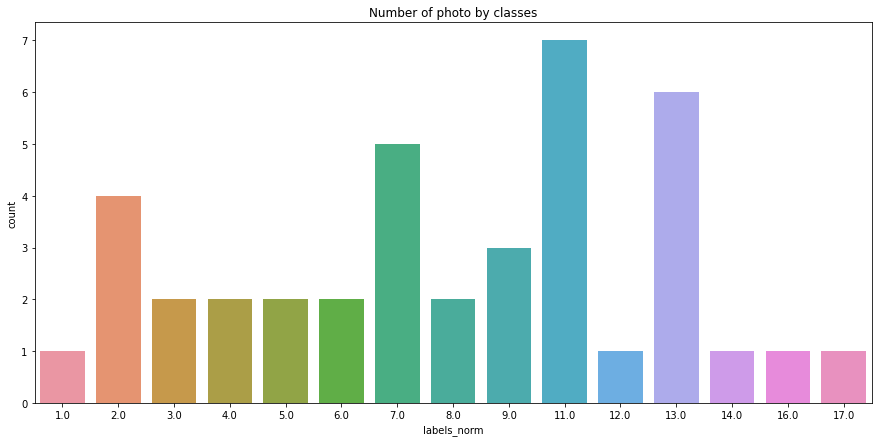

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


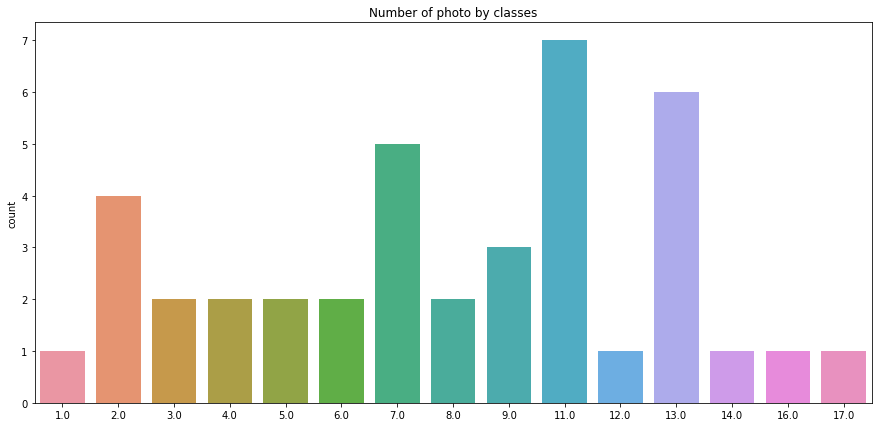

In [ ]:
# Visualisation de la distribution des labels
Y = Etang_01A["labels_norm"]
plt.figure(figsize=(15,7))
sns.countplot(Y)
plt.title("Number of photo by classes")
plt.show()
# Plafonnement des labels à 20 car trop peu de données au dessus
Y_label = np.ones((5,), dtype=int)*20
Y_label = np.where(Etang_01A["labels_norm"]<=20,Etang_01A["labels_norm"],20)
# Visualisation de la distribution des labels
plt.figure(figsize=(15,7))
sns.countplot(Y_label)
plt.title("Number of photo by classes")
plt.show()

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

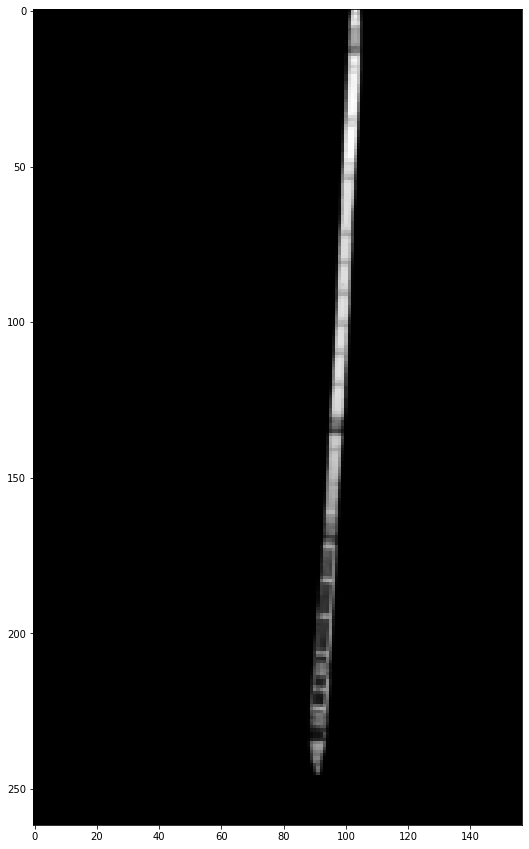

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 7.0 2220913-STSI-E01-0024.JPG


In [ ]:
# Création de la matrice des labels / label encoding
Y_encoding = to_categorical(Y_label, num_classes = 21)
print(Y_encoding,Y_encoding.shape)
# Creation du dataset
X = Etang_01A.drop(labels = ['photos_names', 'Pente', 'labels', 'labels_norm'],axis = 1)
X = X/255
X = X.values.reshape(-1,262,157,1)
# one example
n=23
plt.figure(figsize=(15,15))
plt.imshow(X[n][:,:,0],cmap='gray')
plt.show()
print(Y_encoding[n],Y_label[n],Etang_01A['photos_names'][n])

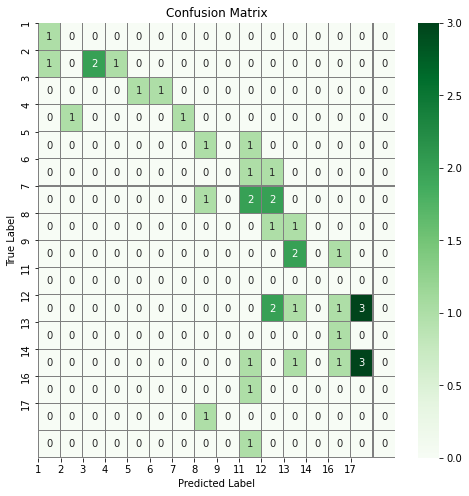

In [ ]:
axe = list(map(int,list(set(Y_label))))
# confusion matrix and predictions
# Predict the values from the validation dataset
Y_pred_new = model.predict(X)
# Convert predictions classes to one hot vectors
Y_pred_new_classes = np.argmax(Y_pred_new,axis = 1)
# Convert validation observations to one hot vectors
Y_true_new = np.argmax(Y_encoding,axis = 1)
# compute the confusion matrix
confusion_new = confusion_matrix(Y_true_new, Y_pred_new_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_new, annot=True, linewidths=0.01,
            cmap="Greens",linecolor="gray", fmt= '',ax=ax)
plt.xlabel("Predicted Label")
plt.xticks(list(range(len(axe))),labels=list(map(int,list(set(Y_label)))))
plt.yticks(list(range(len(axe))),labels=list(map(int,list(set(Y_label)))))
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

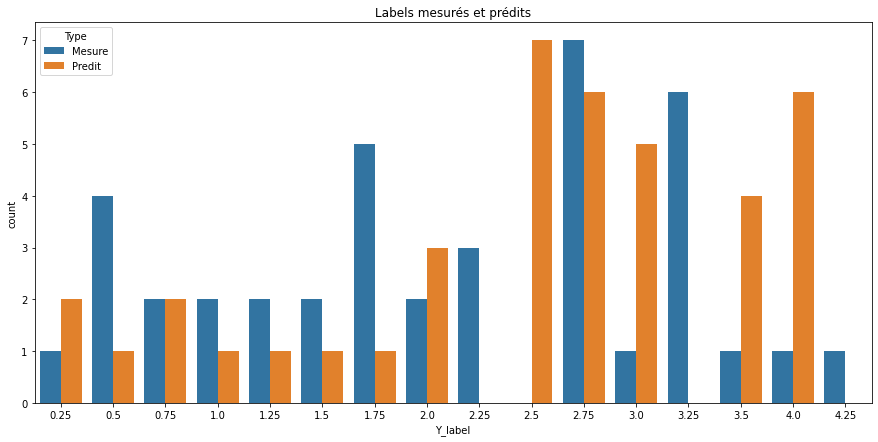

In [ ]:
# Visualisation de la distribution des labels
plt.figure(figsize=(15,7))
res=pd.DataFrame({"Y_label":Y_label/4,"Type":"Mesure"})
res2=pd.DataFrame({"Y_label":Y_pred_new_classes/4,"Type":"Predit"})
res3 = pd.concat([res,res2],ignore_index=True)
sns.countplot(x="Y_label",data=res3,hue="Type")
plt.title("Labels mesurés et prédits")
plt.show()

In [ ]:
# Création du tableau de post_traitement
resultats = Etang_01A[["photos_names","Pente","labels"]]
resultats["labels_predits"] = Y_pred_new_classes/4
resultats.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,photos_names,Pente,labels,labels_predits
0,2220913-STSI-E01-0001.JPG,1,0.50,0.25
1,2220913-STSI-E01-0002.JPG,1,0.50,0.75
2,2220913-STSI-E01-0003.JPG,1,0.50,0.75
3,2220913-STSI-E01-0004.JPG,1,0.75,1.25
4,2220913-STSI-E01-0005.JPG,1,0.75,1.50


In [ ]:
Lf_ref,lf_ref,Heau_ref = 38.2, 18.5, 3.5
# Relation de Lmoy obtenue avec l'hypothèse que P=3*Heau
Lmoy_ref=12*Heau_ref + 2*Lf_ref + 2*lf_ref
print("Lf: {}, lf: {}, Heau: {}, Lmoy: {}".format(Lf_ref,lf_ref,Heau_ref,Lmoy_ref))

Lf: 38.2, lf: 18.5, Heau: 3.5, Lmoy: 155.4


In [ ]:
# calculs des hauteurs moyennes dans le fond et les pentes avec conversion en cm (*30.48)
moy_fond_mesure, moy_fond_predit= resultats[resultats["Pente"]==0][["labels","labels_predits"]].mean()*30.48
print("Moyenne de la hauteur de boue mesurée au fond de l'étang: {:.2f}cm\nMoyenne de la hauteur de boue prédite dans le fond de l'étang: {:.2f}cm".format(moy_fond_mesure, moy_fond_predit))
err_Hboue = (moy_fond_predit-moy_fond_mesure)/moy_fond_mesure*100
print("L'erreur relative du la hauteur de boue dans le fond de l'étang est de: {:.2f}%".format(err_Hboue))
moy_pente_mesure, moy_pente_predit= resultats[resultats["Pente"]==1][["labels","labels_predits"]].mean()*30.48
print("Moyenne de la hauteur de boue mesurée dans les pentes de l'étang: {:.2f}cm\nMoyenne de la hauteur de boue prédite dans les pentes de l'étang: {:.2f}cm".format(moy_pente_mesure, moy_pente_predit))
err_Hmi = (moy_pente_predit-moy_pente_mesure)/moy_pente_mesure*100
if err_Hmi >-100 and err_Hmi < 100:
  print("L'erreur relative du la hauteur de boue à mi-pente est de: {:.2f}%".format(err_Hmi))
else:
  moy_pente_mesure, moy_pente_predit = 0,0
# calcul du volume de boue et l'erreur associée
V_mesure = moy_fond_mesure/100*Lf_ref*lf_ref + Lmoy_ref*3/4*Heau_ref*(moy_fond_mesure/100+2*moy_pente_mesure/100)
V_predit = moy_fond_predit/100*Lf_ref*lf_ref + Lmoy_ref*3/4*Heau_ref*(moy_fond_mesure/100+2*moy_pente_predit/100)
err_Vboue = (V_predit-V_mesure)/V_mesure*100
print("Le volume de boue mesuré est de {:.2f}m3\nLe volume de boue prédit est de {:.2f}m3".format(V_mesure,V_predit))
print("L'erreur relative de prédiction du volume de boue est de {:.2f}%".format(err_Vboue))

Moyenne de la hauteur de boue mesurée au fond de l'étang: 90.17cm
Moyenne de la hauteur de boue prédite dans le fond de l'étang: 96.94cm
L'erreur relative du la hauteur de boue dans le fond de l'étang est de: 7.51%
Moyenne de la hauteur de boue mesurée dans les pentes de l'étang: 42.95cm
Moyenne de la hauteur de boue prédite dans les pentes de l'étang: 60.61cm
L'erreur relative du la hauteur de boue à mi-pente est de: 41.13%
Le volume de boue mesuré est de 1355.46m3
Le volume de boue prédit est de 1547.44m3
L'erreur relative de prédiction du volume de boue est de 14.16%


In [ ]:
liste_colonnes = ["Nom_etang","Erreur_volume (%)","Erreur_Hboue (%)","Erreur_Hmi (%)","Volume_mesure (m3)","Volume_predit (m3)","Hboue_mesure (cm)","Hboue_predit (cm)","Hmi_mesure (cm)","Hmi_predit (cm)","Lf (m)","lf (m)","Heau (m)","Lmoy (m)"]

In [ ]:
df2 = pd.DataFrame([["Etang_01A",err_Vboue,err_Hboue,err_Hmi,V_mesure,V_predit,moy_fond_mesure,moy_fond_predit,moy_pente_mesure, moy_pente_predit,Lf_ref,lf_ref,Heau_ref,Lmoy_ref]],columns=liste_colonnes)
#tab_erreur = tab_erreur.append(df2,ignore_index=True)
#tab_erreur.tail()

In [ ]:
df2.head()
tab_erreur = df2

#### Etang 02




In [ ]:
# Changer les noms pour plus de clarté
# Indiquer les indices pour le premier étang. Ici par exemple on prend les 48 premières lignes, c'est le nombre de photos pour cet étang.
Etang_02 = df_new.iloc[40:80]
Etang_02.reset_index(drop=True,inplace=True)
Etang_02.tail()

,Unnamed: 0,photos_names,labels,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel41125,pixel41126,pixel41127,pixel41128,pixel41129,pixel41130,pixel41131,pixel41132,pixel41133,pixel41134
35,75,2220913-STSI-E02-0036.JPG,0.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,76,2220913-STSI-E02-0037.JPG,1.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,77,2220913-STSI-E02-0038.JPG,1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,78,2220913-STSI-E02-0039.JPG,0.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,79,2220913-STSI-E02-0040.JPG,0.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
base_path + "/" + [i for i in os.listdir(base_path) if i[-4:]=="xlsx"][0]

'/content/drive/MyDrive/Stage_DDC/2220913-STSIMON/Rapport de MissionECH - STSI - 220913.xlsx'

In [ ]:
# Création du dataframe avec les infos de pente et labels
os.listdir(base_path)
pente = pd.read_excel(base_path + "/" + [i for i in os.listdir(base_path) if i[-4:]=="xlsx"][0],sheet_name=1,header=0,usecols="I",nrows=40,na_values=0)
pente.columns=["Pente"]
pente = pente.fillna(0).astype('int')
pente

,Pente
0,1
1,1
2,1
3,1
4,1
5,1
6,0
7,0
8,0
9,1


In [ ]:
# Ajout de la pente et des labels normalisés
del Etang_02["Unnamed: 0"]
Etang_02.insert(1,"Pente",pente)
Etang_02.insert(3,"labels_norm",Etang_02["labels"]*4)
Etang_02.astype({"labels_norm":"int32"}).dtypes

photos_names     object
Pente             int64
labels          float64
labels_norm       int32
pixel1            int64
                 ...   
pixel41130        int64
pixel41131        int64
pixel41132        int64
pixel41133        int64
pixel41134        int64
Length: 41138, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


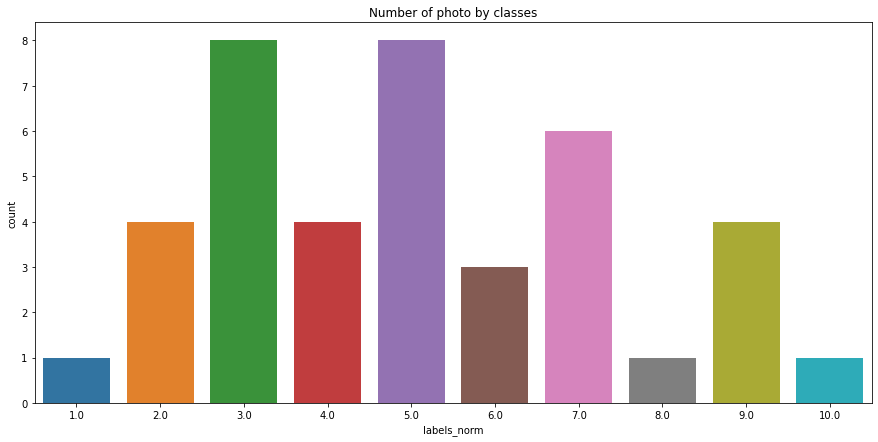

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


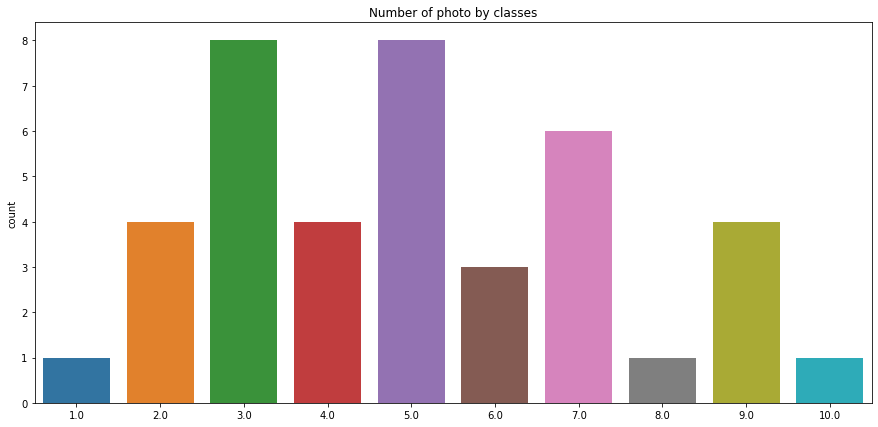

In [ ]:
# Visualisation de la distribution des labels
Y = Etang_02["labels_norm"]
plt.figure(figsize=(15,7))
sns.countplot(Y)
plt.title("Number of photo by classes")
plt.show()
# Plafonnement des labels à 20 car trop peu de données au dessus
Y_label = np.ones((5,), dtype=int)*20
Y_label = np.where(Etang_02["labels_norm"]<=20,Etang_02["labels_norm"],20)
# Visualisation de la distribution des labels
plt.figure(figsize=(15,7))
sns.countplot(Y_label)
plt.title("Number of photo by classes")
plt.show()

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

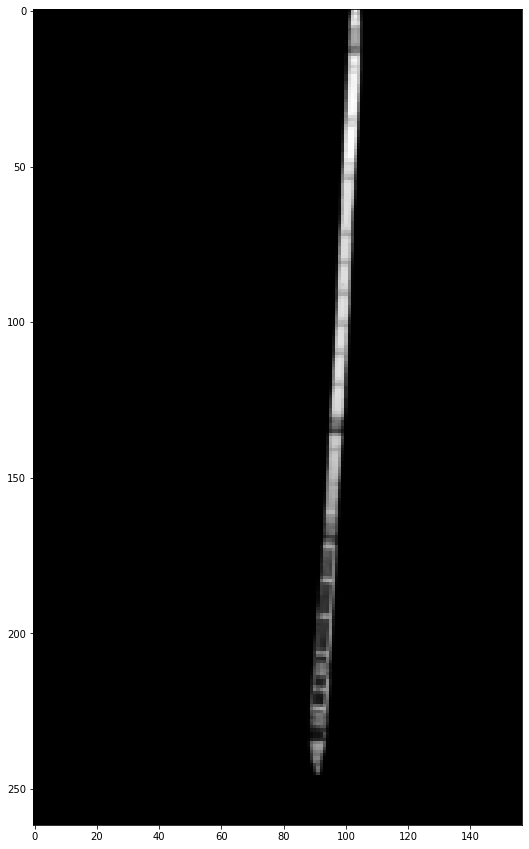

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 7.0 2220913-STSI-E01-0024.JPG


In [ ]:
# Création de la matrice des labels / label encoding
Y_encoding = to_categorical(Y_label, num_classes = 21)
print(Y_encoding,Y_encoding.shape)
# Creation du dataset
X = Etang_02.drop(labels = ['photos_names', 'Pente', 'labels', 'labels_norm'],axis = 1)
X = X/255
X = X.values.reshape(-1,262,157,1)
# one example
n=23
plt.figure(figsize=(15,15))
plt.imshow(X[n][:,:,0],cmap='gray')
plt.show()
print(Y_encoding[n],Y_label[n],Etang_02['photos_names'][n])

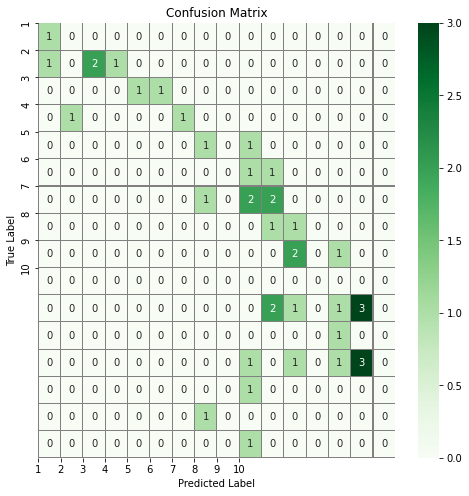

In [ ]:
axe = list(map(int,list(set(Y_label))))
# confusion matrix and predictions
# Predict the values from the validation dataset
Y_pred_new = model.predict(X)
# Convert predictions classes to one hot vectors
Y_pred_new_classes = np.argmax(Y_pred_new,axis = 1)
# Convert validation observations to one hot vectors
Y_true_new = np.argmax(Y_encoding,axis = 1)
# compute the confusion matrix
confusion_new = confusion_matrix(Y_true_new, Y_pred_new_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_new, annot=True, linewidths=0.01,
            cmap="Greens",linecolor="gray", fmt= '',ax=ax)
plt.xlabel("Predicted Label")
plt.xticks(list(range(len(axe))),labels=list(map(int,list(set(Y_label)))))
plt.yticks(list(range(len(axe))),labels=list(map(int,list(set(Y_label)))))
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

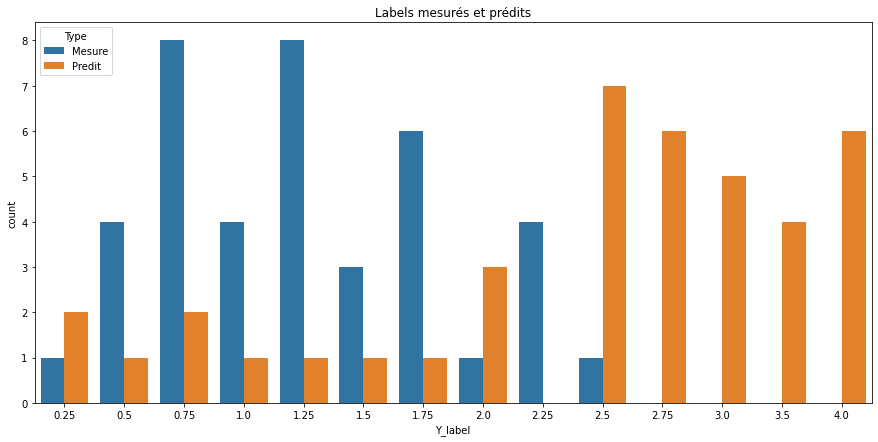

In [ ]:
# Visualisation de la distribution des labels
plt.figure(figsize=(15,7))
res=pd.DataFrame({"Y_label":Y_label/4,"Type":"Mesure"})
res2=pd.DataFrame({"Y_label":Y_pred_new_classes/4,"Type":"Predit"})
res3 = pd.concat([res,res2],ignore_index=True)
sns.countplot(x="Y_label",data=res3,hue="Type")
plt.title("Labels mesurés et prédits")
plt.show()

In [ ]:
# Création du tableau de post_traitement
resultats = Etang_02[["photos_names","Pente","labels"]]
resultats["labels_predits"] = Y_pred_new_classes/4
resultats.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,photos_names,Pente,labels,labels_predits
0,2220913-STSI-E02-0001.JPG,1,0.50,0.25
1,2220913-STSI-E02-0002.JPG,1,0.25,0.75
2,2220913-STSI-E02-0003.JPG,1,0.50,0.75
3,2220913-STSI-E02-0004.JPG,1,0.50,1.25
4,2220913-STSI-E02-0005.JPG,1,0.75,1.50


In [ ]:
Lf_ref,lf_ref,Heau_ref = 38.2, 18.5, 3.5
# Relation de Lmoy obtenue avec l'hypothèse que P=3*Heau
Lmoy_ref=12*Heau_ref + 2*Lf_ref + 2*lf_ref
print("Lf: {}, lf: {}, Heau: {}, Lmoy: {}".format(Lf_ref,lf_ref,Heau_ref,Lmoy_ref))

Lf: 38.2, lf: 18.5, Heau: 3.5, Lmoy: 155.4


In [ ]:
# calculs des hauteurs moyennes dans le fond et les pentes avec conversion en cm (*30.48)
moy_fond_mesure, moy_fond_predit= resultats[resultats["Pente"]==0][["labels","labels_predits"]].mean()*30.48
print("Moyenne de la hauteur de boue mesurée au fond de l'étang: {:.2f}cm\nMoyenne de la hauteur de boue prédite dans le fond de l'étang: {:.2f}cm".format(moy_fond_mesure, moy_fond_predit))
err_Hboue = (moy_fond_predit-moy_fond_mesure)/moy_fond_mesure*100
print("L'erreur relative du la hauteur de boue dans le fond de l'étang est de: {:.2f}%".format(err_Hboue))
moy_pente_mesure, moy_pente_predit= resultats[resultats["Pente"]==1][["labels","labels_predits"]].mean()*30.48
print("Moyenne de la hauteur de boue mesurée dans les pentes de l'étang: {:.2f}cm\nMoyenne de la hauteur de boue prédite dans les pentes de l'étang: {:.2f}cm".format(moy_pente_mesure, moy_pente_predit))
err_Hmi = (moy_pente_predit-moy_pente_mesure)/moy_pente_mesure*100
if err_Hmi >-100 and err_Hmi < 100:
  print("L'erreur relative du la hauteur de boue à mi-pente est de: {:.2f}%".format(err_Hmi))
else:
  moy_pente_mesure, moy_pente_predit = 0,0
# calcul du volume de boue et l'erreur associée
V_mesure = moy_fond_mesure/100*Lf_ref*lf_ref + Lmoy_ref*3/4*Heau_ref*(moy_fond_mesure/100+2*moy_pente_mesure/100)
V_predit = moy_fond_predit/100*Lf_ref*lf_ref + Lmoy_ref*3/4*Heau_ref*(moy_fond_mesure/100+2*moy_pente_predit/100)
err_Vboue = (V_predit-V_mesure)/V_mesure*100
print("Le volume de boue mesuré est de {:.2f}m3\nLe volume de boue prédit est de {:.2f}m3".format(V_mesure,V_predit))
print("L'erreur relative de prédiction du volume de boue est de {:.2f}%".format(err_Vboue))

Moyenne de la hauteur de boue mesurée au fond de l'étang: 52.49cm
Moyenne de la hauteur de boue prédite dans le fond de l'étang: 96.94cm
L'erreur relative du la hauteur de boue dans le fond de l'étang est de: 84.68%
Moyenne de la hauteur de boue mesurée dans les pentes de l'étang: 27.36cm
Moyenne de la hauteur de boue prédite dans les pentes de l'étang: 60.61cm
Le volume de boue mesuré est de 585.10m3
Le volume de boue prédit est de 899.23m3
L'erreur relative de prédiction du volume de boue est de 53.69%


In [ ]:
df2 = pd.DataFrame([["Etang_02",err_Vboue,err_Hboue,err_Hmi,V_mesure,V_predit,moy_fond_mesure,moy_fond_predit,moy_pente_mesure, moy_pente_predit,Lf_ref,lf_ref,Heau_ref,Lmoy_ref]],columns=liste_colonnes)
tab_erreur = tab_erreur.append(df2,ignore_index=True)
tab_erreur.tail()

,Nom_etang,Erreur_volume (%),Erreur_Hboue (%),Erreur_Hmi (%),Volume_mesure (m3),Volume_predit (m3),Hboue_mesure (cm),Hboue_predit (cm),Hmi_mesure (cm),Hmi_predit (cm),Lf (m),lf (m),Heau (m),Lmoy (m)
0,Etang_01A,14.163730,7.511737,41.129032,1355.457521,1547.440861,90.170000,96.943333,42.949091,60.613636,38.2,18.5,3.5,155.4
1,Etang_02,53.687592,84.677419,121.518987,585.103817,899.231967,52.493333,96.943333,0.000000,0.000000,38.2,18.5,3.5,155.4


#### Etang 03




In [ ]:
# Changer les noms pour plus de clarté
# Indiquer les indices pour le premier étang. Ici par exemple on prend les 48 premières lignes, c'est le nombre de photos pour cet étang.
Etang_03 = df_new.iloc[80:120]
Etang_03.reset_index(drop=True,inplace=True)
Etang_03.tail()

,Unnamed: 0,photos_names,labels,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel41125,pixel41126,pixel41127,pixel41128,pixel41129,pixel41130,pixel41131,pixel41132,pixel41133,pixel41134
35,115,2220913-STSI-E03-0036.JPG,1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,116,2220913-STSI-E03-0037.JPG,0.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,117,2220913-STSI-E03-0038.JPG,0.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,118,2220913-STSI-E03-0039.JPG,0.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,119,2220913-STSI-E03-0040.JPG,0.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Création du dataframe avec les infos de pente et labels
os.listdir(base_path)
pente = pd.read_excel(base_path + "/" + [i for i in os.listdir(base_path) if i[-4:]=="xlsx"][0],sheet_name=2,header=0,usecols="I",nrows=40,na_values=0)
pente.columns=["Pente"]
pente = pente.fillna(0).astype('int')
pente

,Pente
0,1
1,1
2,1
3,1
4,1
5,1
6,0
7,0
8,0
9,1


In [ ]:
# Ajout de la pente et des labels normalisés
del Etang_03["Unnamed: 0"]
Etang_03.insert(1,"Pente",pente)
Etang_03.insert(3,"labels_norm",Etang_03["labels"]*4)
Etang_03.astype({"labels_norm":"int32"}).dtypes

photos_names     object
Pente             int64
labels          float64
labels_norm       int32
pixel1            int64
                 ...   
pixel41130        int64
pixel41131        int64
pixel41132        int64
pixel41133        int64
pixel41134        int64
Length: 41138, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


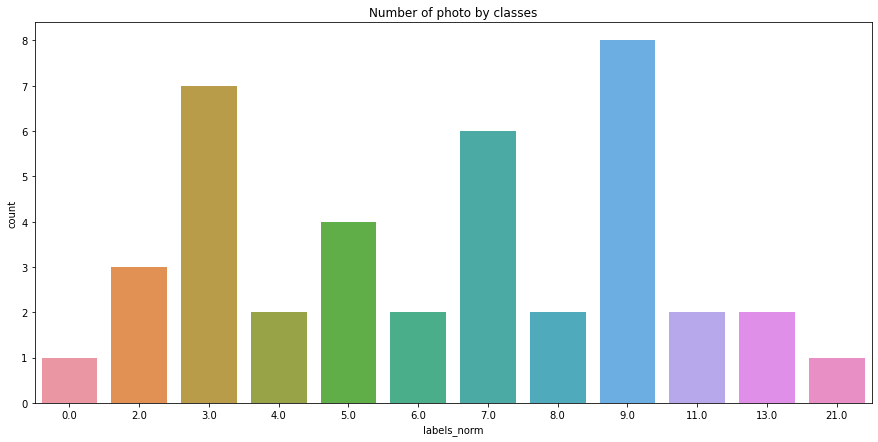

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


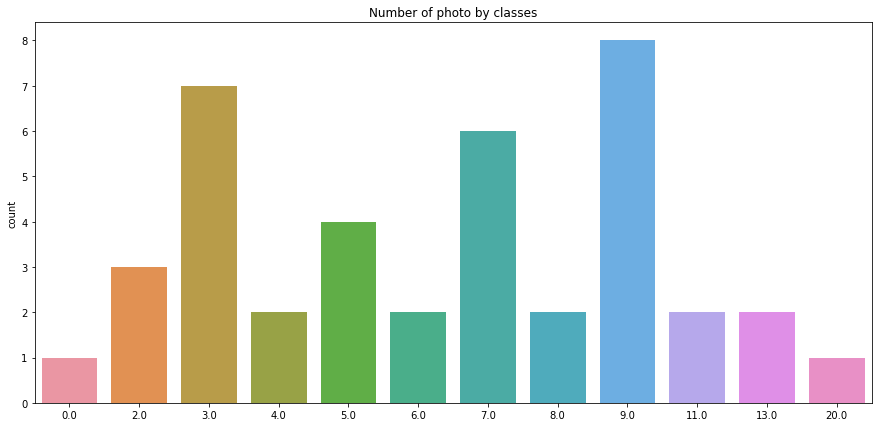

In [ ]:
# Visualisation de la distribution des labels
Y = Etang_03["labels_norm"]
plt.figure(figsize=(15,7))
sns.countplot(Y)
plt.title("Number of photo by classes")
plt.show()
# Plafonnement des labels à 20 car trop peu de données au dessus
Y_label = np.ones((5,), dtype=int)*20
Y_label = np.where(Etang_03["labels_norm"]<=20,Etang_03["labels_norm"],20)
# Visualisation de la distribution des labels
plt.figure(figsize=(15,7))
sns.countplot(Y_label)
plt.title("Number of photo by classes")
plt.show()

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

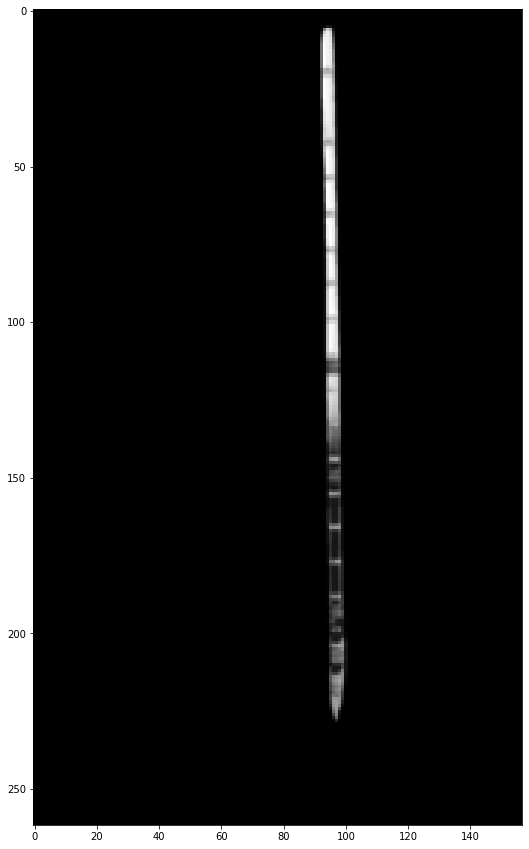

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 9.0 2220913-STSI-E03-0024.JPG


In [ ]:
# Création de la matrice des labels / label encoding
Y_encoding = to_categorical(Y_label, num_classes = 21)
print(Y_encoding,Y_encoding.shape)
# Creation du dataset
X = Etang_03.drop(labels = ['photos_names', 'Pente', 'labels', 'labels_norm'],axis = 1)
X = X/255
X = X.values.reshape(-1,262,157,1)
# one example
n=23
plt.figure(figsize=(15,15))
plt.imshow(X[n][:,:,0],cmap='gray')
plt.show()
print(Y_encoding[n],Y_label[n],Etang_03['photos_names'][n])

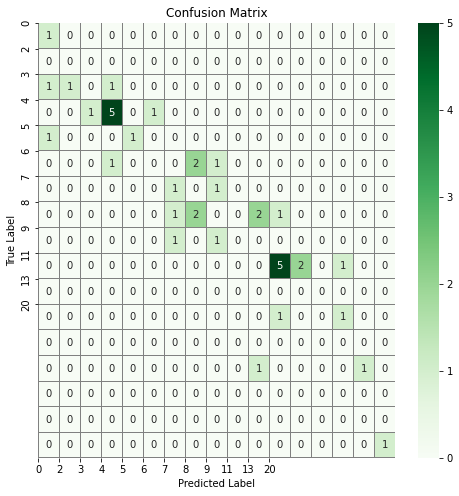

In [ ]:
axe = list(map(int,list(set(Y_label))))
# confusion matrix and predictions
# Predict the values from the validation dataset
Y_pred_new = model.predict(X)
# Convert predictions classes to one hot vectors
Y_pred_new_classes = np.argmax(Y_pred_new,axis = 1)
# Convert validation observations to one hot vectors
Y_true_new = np.argmax(Y_encoding,axis = 1)
# compute the confusion matrix
confusion_new = confusion_matrix(Y_true_new, Y_pred_new_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_new, annot=True, linewidths=0.01,
            cmap="Greens",linecolor="gray", fmt= '',ax=ax)
plt.xlabel("Predicted Label")
plt.xticks(list(range(len(axe))),labels=list(map(int,list(set(Y_label)))))
plt.yticks(list(range(len(axe))),labels=list(map(int,list(set(Y_label)))))
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

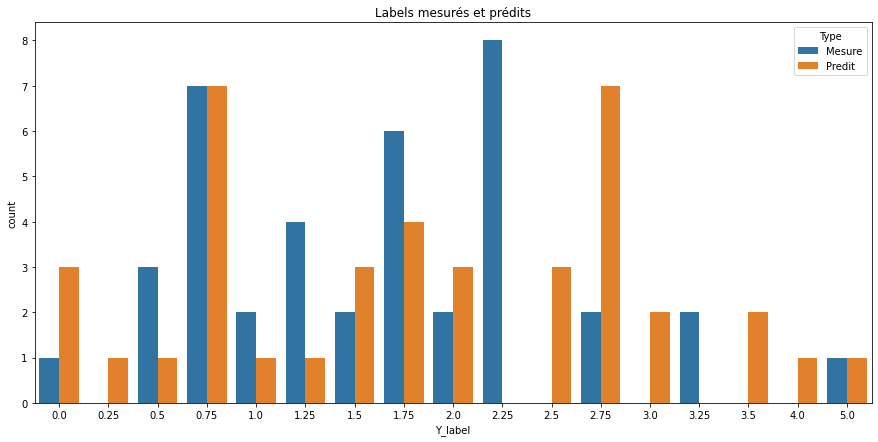

In [ ]:
# Visualisation de la distribution des labels
plt.figure(figsize=(15,7))
res=pd.DataFrame({"Y_label":Y_label/4,"Type":"Mesure"})
res2=pd.DataFrame({"Y_label":Y_pred_new_classes/4,"Type":"Predit"})
res3 = pd.concat([res,res2],ignore_index=True)
sns.countplot(x="Y_label",data=res3,hue="Type")
plt.title("Labels mesurés et prédits")
plt.show()

In [ ]:
# Création du tableau de post_traitement
resultats = Etang_03[["photos_names","Pente","labels"]]
resultats["labels_predits"] = Y_pred_new_classes/4
resultats.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,photos_names,Pente,labels,labels_predits
0,2220913-STSI-E03-0001.JPG,1,0.50,0.75
1,2220913-STSI-E03-0002.JPG,1,0.00,0.00
2,2220913-STSI-E03-0003.JPG,1,0.75,0.75
3,2220913-STSI-E03-0004.JPG,1,0.50,0.25
4,2220913-STSI-E03-0005.JPG,1,0.50,0.00


In [ ]:
Lf_ref,lf_ref,Heau_ref = 38.2, 18.5, 3.5
# Relation de Lmoy obtenue avec l'hypothèse que P=3*Heau
Lmoy_ref=12*Heau_ref + 2*Lf_ref + 2*lf_ref
print("Lf: {}, lf: {}, Heau: {}, Lmoy: {}".format(Lf_ref,lf_ref,Heau_ref,Lmoy_ref))

Lf: 38.2, lf: 18.5, Heau: 3.5, Lmoy: 155.4


In [ ]:
# calculs des hauteurs moyennes dans le fond et les pentes avec conversion en cm (*30.48)
moy_fond_mesure, moy_fond_predit= resultats[resultats["Pente"]==0][["labels","labels_predits"]].mean()*30.48
print("Moyenne de la hauteur de boue mesurée au fond de l'étang: {:.2f}cm\nMoyenne de la hauteur de boue prédite dans le fond de l'étang: {:.2f}cm".format(moy_fond_mesure, moy_fond_predit))
err_Hboue = (moy_fond_predit-moy_fond_mesure)/moy_fond_mesure*100
print("L'erreur relative du la hauteur de boue dans le fond de l'étang est de: {:.2f}%".format(err_Hboue))
moy_pente_mesure, moy_pente_predit= resultats[resultats["Pente"]==1][["labels","labels_predits"]].mean()*30.48
print("Moyenne de la hauteur de boue mesurée dans les pentes de l'étang: {:.2f}cm\nMoyenne de la hauteur de boue prédite dans les pentes de l'étang: {:.2f}cm".format(moy_pente_mesure, moy_pente_predit))
err_Hmi = (moy_pente_predit-moy_pente_mesure)/moy_pente_mesure*100
if err_Hmi >-100 and err_Hmi < 100:
  print("L'erreur relative du la hauteur de boue à mi-pente est de: {:.2f}%".format(err_Hmi))
else:
  moy_pente_mesure, moy_pente_predit = 0,0
# calcul du volume de boue et l'erreur associée
V_mesure = moy_fond_mesure/100*Lf_ref*lf_ref + Lmoy_ref*3/4*Heau_ref*(moy_fond_mesure/100+2*moy_pente_mesure/100)
V_predit = moy_fond_predit/100*Lf_ref*lf_ref + Lmoy_ref*3/4*Heau_ref*(moy_fond_mesure/100+2*moy_pente_predit/100)
err_Vboue = (V_predit-V_mesure)/V_mesure*100
print("Le volume de boue mesuré est de {:.2f}m3\nLe volume de boue prédit est de {:.2f}m3".format(V_mesure,V_predit))
print("L'erreur relative de prédiction du volume de boue est de {:.2f}%".format(err_Vboue))

Moyenne de la hauteur de boue mesurée au fond de l'étang: 74.08cm
Moyenne de la hauteur de boue prédite dans le fond de l'étang: 88.05cm
L'erreur relative du la hauteur de boue dans le fond de l'étang est de: 18.86%
Moyenne de la hauteur de boue mesurée dans les pentes de l'étang: 31.52cm
Moyenne de la hauteur de boue prédite dans les pentes de l'étang: 31.17cm
L'erreur relative du la hauteur de boue à mi-pente est de: -1.10%
Le volume de boue mesuré est de 1082.90m3
Le volume de boue prédit est de 1178.80m3
L'erreur relative de prédiction du volume de boue est de 8.86%


In [ ]:
df2 = pd.DataFrame([["Etang_03",err_Vboue,err_Hboue,err_Hmi,V_mesure,V_predit,moy_fond_mesure,moy_fond_predit,moy_pente_mesure, moy_pente_predit,Lf_ref,lf_ref,Heau_ref,Lmoy_ref]],columns=liste_colonnes)
tab_erreur = tab_erreur.append(df2,ignore_index=True)
tab_erreur.tail()

,Nom_etang,Erreur_volume (%),Erreur_Hboue (%),Erreur_Hmi (%),Volume_mesure (m3),Volume_predit (m3),Hboue_mesure (cm),Hboue_predit (cm),Hmi_mesure (cm),Hmi_predit (cm),Lf (m),lf (m),Heau (m),Lmoy (m)
0,Etang_01A,14.163730,7.511737,41.129032,1355.457521,1547.440861,90.170000,96.943333,42.949091,60.613636,38.2,18.5,3.5,155.4
1,Etang_02,53.687592,84.677419,121.518987,585.103817,899.231967,52.493333,96.943333,0.000000,0.000000,38.2,18.5,3.5,155.4
2,Etang_03,8.855868,18.857143,-1.098901,1082.899857,1178.800040,74.083333,88.053333,31.519091,31.172727,38.2,18.5,3.5,155.4


### Analyse

In [ ]:
tab_erreur_new = tab_erreur[-3:]
data_new_LECE,data_new_transit, data_new_transit_deux =pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
data_new_LECE["labels_norm"] = Etang_01A["labels_norm"]
data_new_LECE["Etang"] = "01A"
data_new_transit["labels_norm"] = Etang_02["labels_norm"]
data_new_transit["Etang"] = "02"
data_new_LECE = data_new_LECE.append(data_new_transit,ignore_index=True)
data_new_transit_deux["labels_norm"] = Etang_03["labels_norm"]
data_new_transit_deux["Etang"] = "03"
data_new_LECE = data_new_LECE.append(data_new_transit_deux,ignore_index=True)
data_new_LECE["labels_norm"] = data_new_LECE["labels_norm"]/4
data_new_LECE.tail()

,labels_norm,Etang
115,1.00,03
116,0.75,03
117,0.75,03
118,0.75,03
119,0.75,03


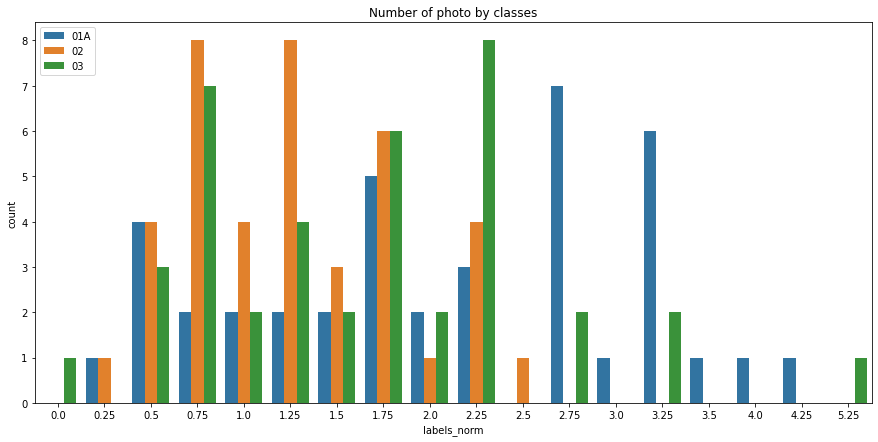

In [ ]:
# Visualisation de la distribution des labels
plt.figure(figsize=(15,7))
sns.countplot(x="labels_norm",data=data_new_LECE,hue="Etang")
plt.title("Number of photo by classes")
plt.legend(loc="upper left")
plt.show()

In [ ]:
tab_erreur_new.head()

,Nom_etang,Erreur_volume (%),Erreur_Hboue (%),Erreur_Hmi (%),Volume_mesure (m3),Volume_predit (m3),Hboue_mesure (cm),Hboue_predit (cm),Hmi_mesure (cm),Hmi_predit (cm),Lf (m),lf (m),Heau (m),Lmoy (m)
0,Etang_01A,14.163730,7.511737,41.129032,1355.457521,1547.440861,90.170000,96.943333,42.949091,60.613636,38.2,18.5,3.5,155.4
1,Etang_02,53.687592,84.677419,121.518987,585.103817,899.231967,52.493333,96.943333,0.000000,0.000000,38.2,18.5,3.5,155.4
2,Etang_03,8.855868,18.857143,-1.098901,1082.899857,1178.800040,74.083333,88.053333,31.519091,31.172727,38.2,18.5,3.5,155.4


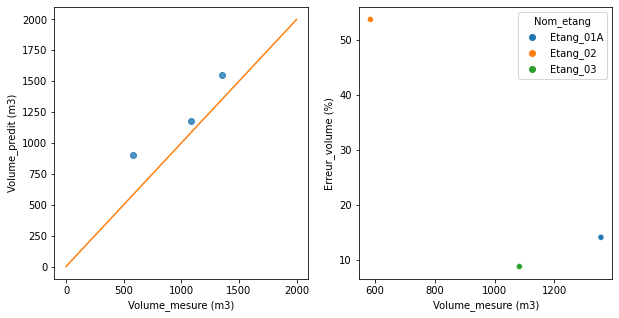

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
sns.regplot(x="Volume_mesure (m3)",y="Volume_predit (m3)",data=tab_erreur_new,ax=ax[0],fit_reg=False)
sns.lineplot(x=[0,2000],y=[0,2000],ax=ax[0])
sns.scatterplot(x="Volume_mesure (m3)",y="Erreur_volume (%)",data=tab_erreur_new,ax=ax[1],hue="Nom_etang")
plt.show()

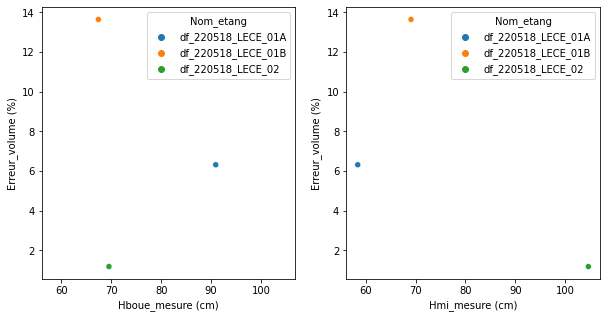

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(10,5),sharex=True)
sns.scatterplot(x="Hboue_mesure (cm)",y="Erreur_volume (%)",data=tab_erreur_new,ax=ax[0],hue="Nom_etang")
sns.scatterplot(x="Hmi_mesure (cm)",y="Erreur_volume (%)",data=tab_erreur_new,ax=ax[1],hue="Nom_etang")
plt.show()